### Dataset Preparation
***Took reference from papers***
- Development of the Combined Assessment of Risk Encountered in Surgery (CARES) surgical risk calculator for prediction of postsurgical mortality and need for intensive care unit admission risk: a single-center retrospective study
- ...

***Research Findings***
- From our research, are there any risk factors that are particularly associated with outcomes (30 day mortality, ICU admission 24H, Days from surgery to mortality)(30 day mortality, ICU admission 24H, Days from surgery to mortality)? 
- Possible to engineer additional critical features as risk-factors? 
- Are we able to combine outcomes/engineer other outcomes?

***Project Workflow***
1. **Data Wrangling & Preparation**
- Drop duplicated records
- Missing value imputation (Research-based)
- Feature engineering (Research-based)
2. **Risk-Factor Analysis**
- Clustering - Findings? 
- Exploratory Analysis & univariate analysis (*can include binning - eg. age binning) - Match findings? *Risk factor selection
- Leveraging on explanability of Tree-Based Models to determine "feature importance" - Further validate risk factors we select for predictive modelling.
- Modelling of Risk-Factors: Explore different models (start with linear & logistic regression)
3. **Predictive Modelling**

In [1]:
# pip install duckdb


[notice] A new release of pip is available: 23.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
from duckdb import sql

In [3]:
# Import dataset
data = pd.read_csv("../data/CARES_data_imputedv1.csv")

In [4]:
data.head()

,GENDER,RCRI_score,Anemia category,Preoptransfusionwithin30days,Intraop,Postopwithin30days,Transfusionintraandpostop,AnaestypeCategory,PriorityCategory,TransfusionIntraandpostopCategory,...,RaceCategory,CVARCRICategory,IHDRCRICategory,CHFRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory,GradeofKidneyCategory,RDW15.7,ASAcategorybinned,ICUAdmgt24h
0,FEMALE,0,mild,0.0,0.0,0.0,0.0,GA,Elective,0 units,...,Chinese,no,no,no,no,no,G1,<= 15.7,I,no
1,MALE,0,moderate/severe,0.0,1.0,0.0,1.0,GA,Elective,1 unit,...,Chinese,no,no,no,no,no,G1,<= 15.7,I,no
2,MALE,0,mild,0.0,0.0,0.0,0.0,GA,Elective,0 units,...,Chinese,no,no,no,no,no,G1,>15.7,II,no
3,MALE,0,none,0.0,0.0,0.0,0.0,GA,Emergency,0 units,...,Indian,no,no,no,no,no,G1,<= 15.7,I,no
4,FEMALE,0,none,0.0,0.0,0.0,0.0,GA,Elective,0 units,...,Chinese,no,no,no,no,no,G2,<= 15.7,II,no


In [5]:
len(data)

69667

In [6]:
data.columns

Index(['GENDER', 'RCRI_score', 'Anemia category',
       'Preoptransfusionwithin30days', 'Intraop', 'Postopwithin30days',
       'Transfusionintraandpostop', 'AnaestypeCategory', 'PriorityCategory',
       'TransfusionIntraandpostopCategory', 'AGEcategory', 'Mortality',
       'thirtydaymortality', 'SurgRiskCategory', 'RaceCategory',
       'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory',
       'DMinsulinRCRICategory', 'CreatinineRCRICategory',
       'GradeofKidneyCategory', 'RDW15.7', 'ASAcategorybinned', 'ICUAdmgt24h'],
      dtype='object')

#### Dataset Preparation

In [7]:
# Define target column for correlation analysis
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']
target_var = 'ICUAdmgt24h'
target_value = 'yes'
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
cat_cols = ['GENDER', 'Anemia category', 'AnaestypeCategory', 'PriorityCategory', 'TransfusionIntraandpostopCategory', 'AGEcategory', 'SurgRiskCategory', \
           'RaceCategory', 'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory', 'GradeofKidneyCategory', 'RDW15.7', 'ASAcategorybinned']

In [8]:
numerical_cols

['RCRI_score',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop']

In [9]:
data['ICUAdmgt24h'].value_counts()

ICUAdmgt24h
no     68498
yes     1169
Name: count, dtype: int64

In [10]:
# info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69667 entries, 0 to 69666
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GENDER                             69667 non-null  object 
 1   RCRI_score                         69667 non-null  int64  
 2   Anemia category                    69667 non-null  object 
 3   Preoptransfusionwithin30days       69667 non-null  float64
 4   Intraop                            69667 non-null  float64
 5   Postopwithin30days                 69667 non-null  float64
 6   Transfusionintraandpostop          69667 non-null  float64
 7   AnaestypeCategory                  69667 non-null  object 
 8   PriorityCategory                   69667 non-null  object 
 9   TransfusionIntraandpostopCategory  69667 non-null  object 
 10  AGEcategory                        69667 non-null  object 
 11  Mortality                          69667 non-null  obj

In [21]:
# Define categorical, numeric & target columns
# Define the target columns
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']

# Select categorical columns and exclude target columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
cat_cols = [col for col in cat_cols if col not in target_cols]

# Select numerical columns and exclude target columns
num_cols = data.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col not in target_cols]

In [22]:
cat_cols

['GENDER',
 'Anemia category',
 'AnaestypeCategory',
 'PriorityCategory',
 'TransfusionIntraandpostopCategory',
 'AGEcategory',
 'SurgRiskCategory',
 'RaceCategory',
 'CVARCRICategory',
 'IHDRCRICategory',
 'CHFRCRICategory',
 'DMinsulinRCRICategory',
 'CreatinineRCRICategory',
 'GradeofKidneyCategory',
 'RDW15.7',
 'ASAcategorybinned']

In [23]:
num_cols

['RCRI_score',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop']

In [24]:
target_cols

['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']

#### Correlations for Categorical Variables

**Important features (ICUAdmgt24h)**
- Categorical features: ALL except 'RaceCategory'
- Numerical features: 'RCRI_score', 'Preoptransfusionwithin30days','Intraop'. 

In [11]:
def correlation_counts(data, cat_cols, target_var='ICUAdmgt24h'):
    """
    Compute and visualize the proportion of each category for categorical variables where target_var equals target_value.

    Parameters:
    data (pd.DataFrame): The input dataframe.
    cat_cols (list): List of categorical columns to analyze.
    target_var (str): The target variable name. Default is 'ICUAdmgt24h'.
    target_value (str): The target value to compute proportions for. Default is 'yes'.

    Returns:
    None
    """
    for col in cat_cols:
        if col in data.columns:
            # Compute the proportions
            total_counts = data[col].value_counts()
            yes_counts = data[data[target_var] == target_value][col].value_counts()
            proportions = yes_counts / total_counts
            proportions = proportions.fillna(0)  # Fill NaN values with 0
            
            print(f"Proportions for {col} when {target_var} is '{target_value}':\n{proportions}\n")
            
            # Plot the proportions
            plt.figure(figsize=(10, 6))
            sns.barplot(x=proportions.index, y=proportions.values)
            plt.title(f'Proportion of {col} when {target_var} is "{target_value}"')
            plt.ylabel('Proportion')
            plt.xlabel(col)
            plt.ylim(0, proportions.max() + 0.05)  # Adjust y-axis scale for better visibility
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column {col} is not in the dataframe.")

Proportions for GENDER when ICUAdmgt24h is 'yes':
GENDER
FEMALE    0.012564
MALE      0.021060
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


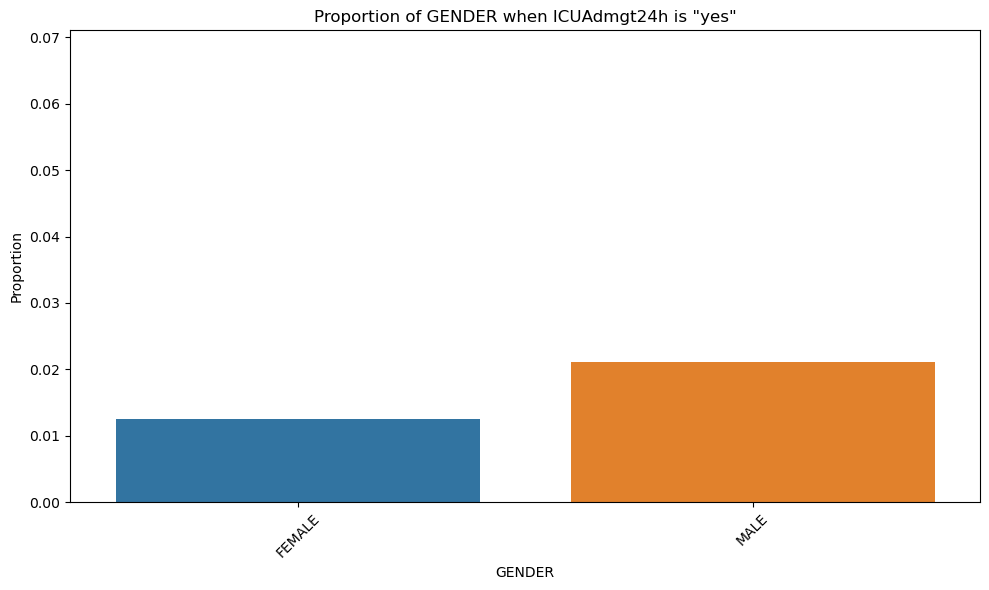

Proportions for Anemia category when ICUAdmgt24h is 'yes':
Anemia category
mild               0.021829
moderate/severe    0.043670
none               0.009997
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


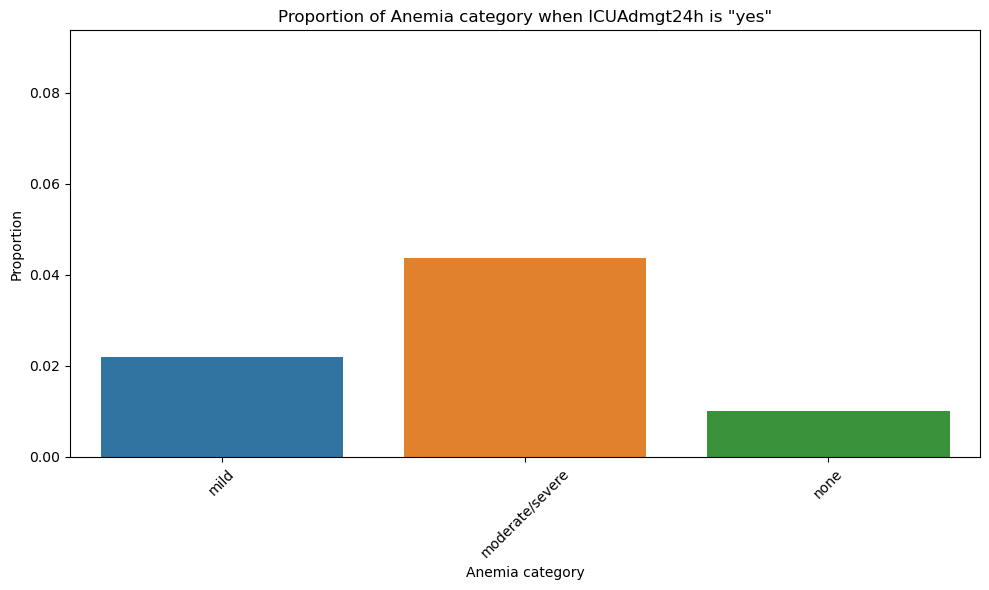

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Proportions for AnaestypeCategory when ICUAdmgt24h is 'yes':
AnaestypeCategory
GA    0.019087
RA    0.004866
Name: count, dtype: float64



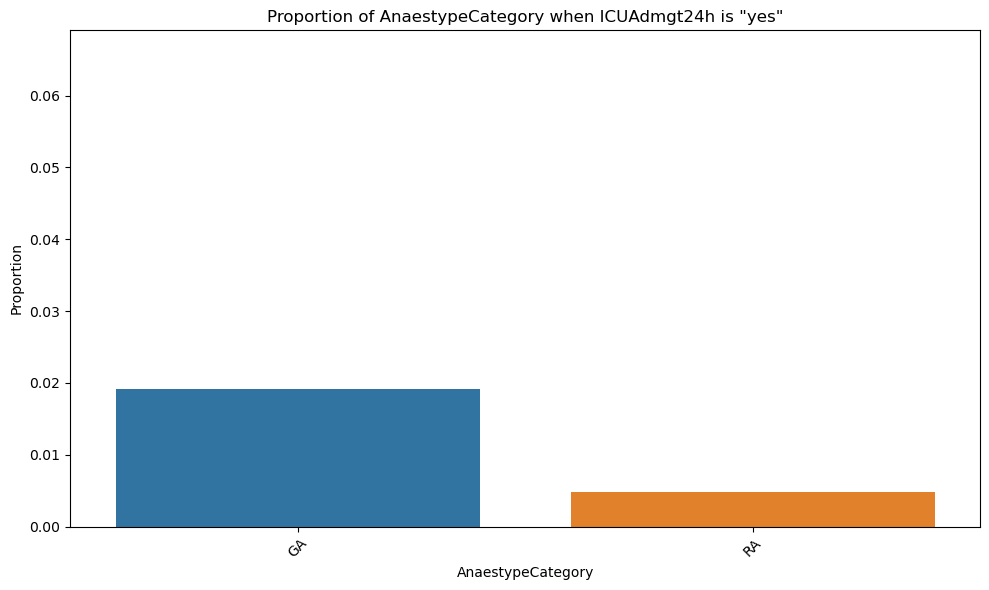

Proportions for PriorityCategory when ICUAdmgt24h is 'yes':
PriorityCategory
Elective     0.011076
Emergency    0.036135
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


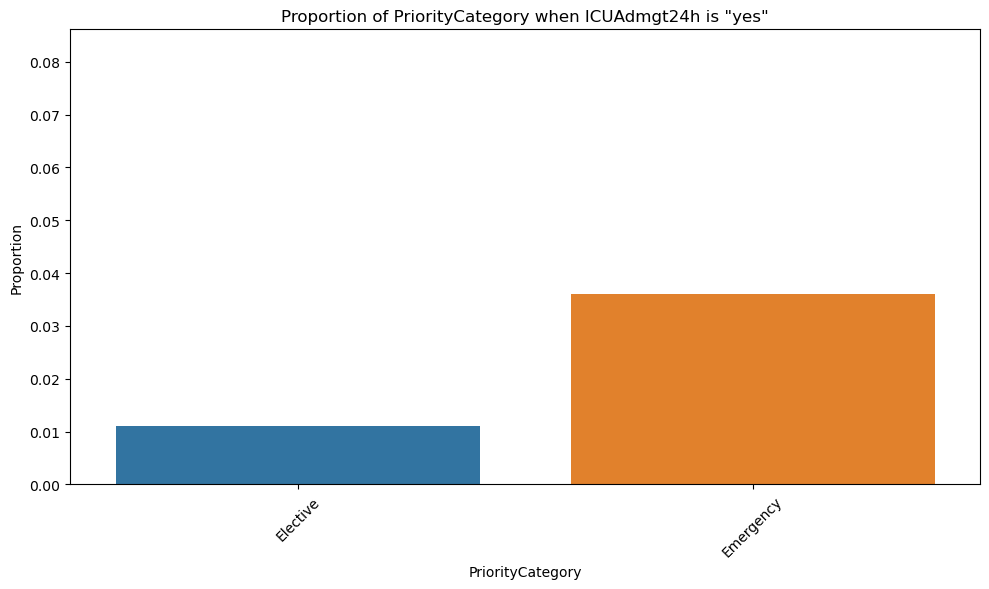

Proportions for TransfusionIntraandpostopCategory when ICUAdmgt24h is 'yes':
TransfusionIntraandpostopCategory
0 units            0.010469
1 unit             0.103848
2 or more units    0.103261
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


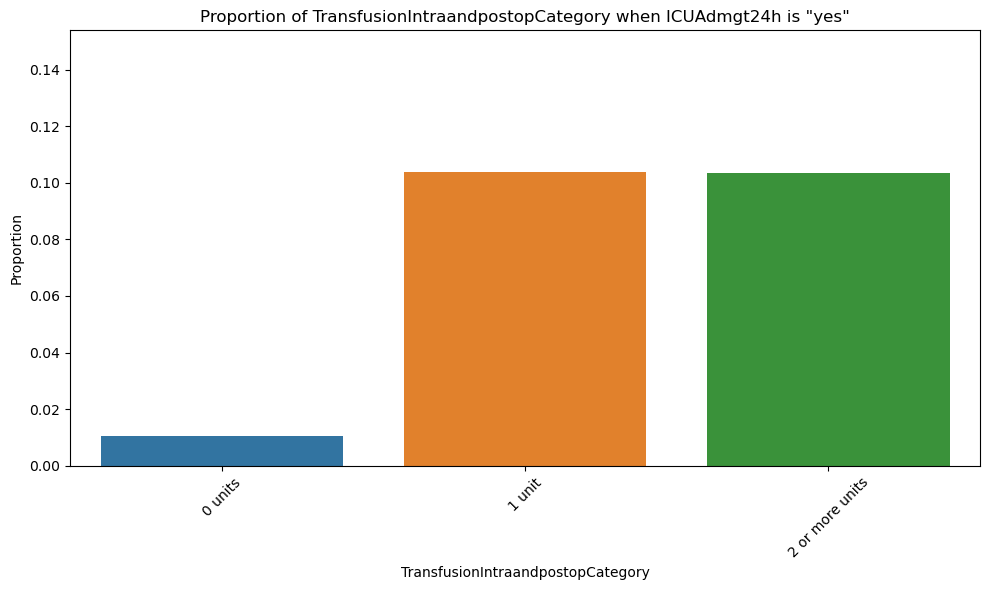

Proportions for AGEcategory when ICUAdmgt24h is 'yes':
AGEcategory
18-29    0.005728
30-49    0.008703
50-64    0.015920
65-74    0.024355
75-84    0.034949
>=85     0.041022
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


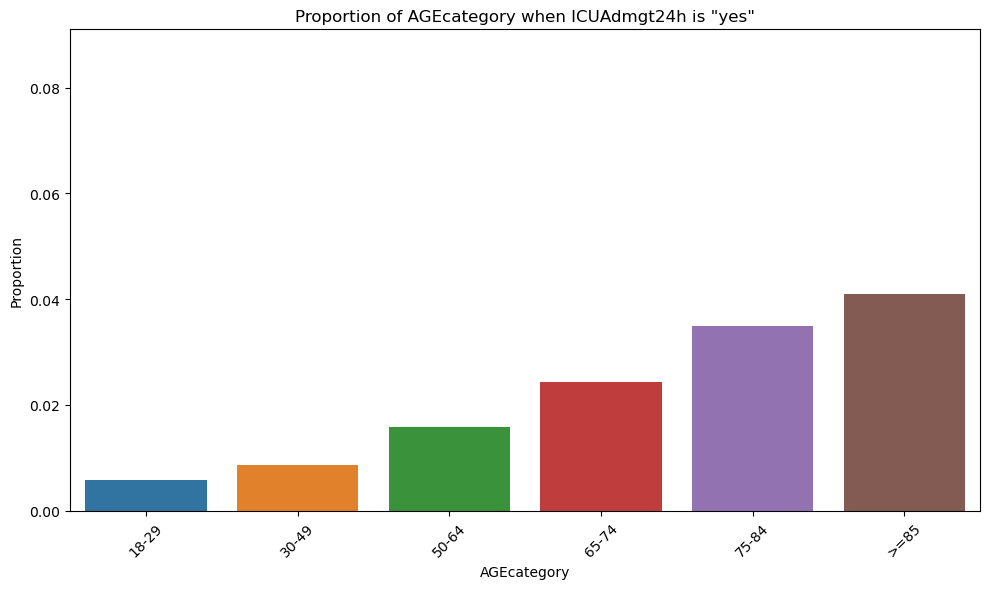

Proportions for SurgRiskCategory when ICUAdmgt24h is 'yes':
SurgRiskCategory
High        0.114321
Low         0.005649
Moderate    0.019053
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


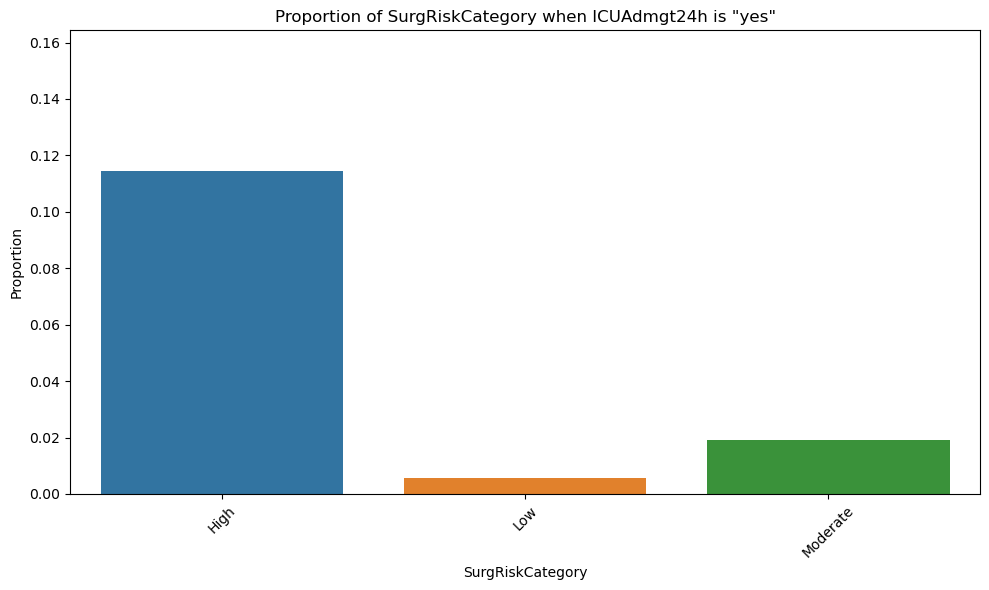

Proportions for RaceCategory when ICUAdmgt24h is 'yes':
RaceCategory
Chinese    0.017406
Malay      0.014937
Others     0.015244
Indian     0.015880
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


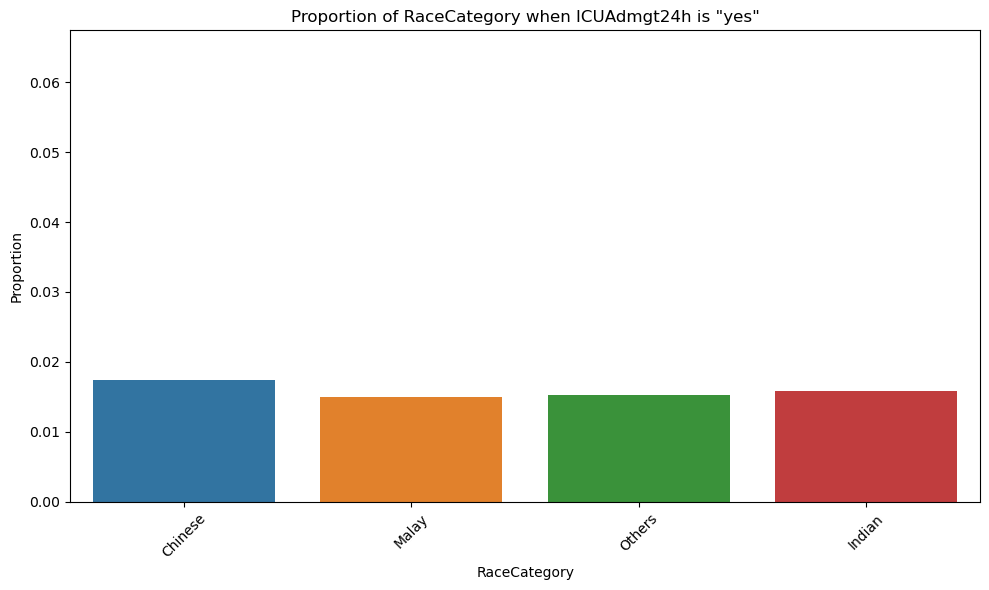

Proportions for CVARCRICategory when ICUAdmgt24h is 'yes':
CVARCRICategory
no     0.016342
yes    0.036716
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


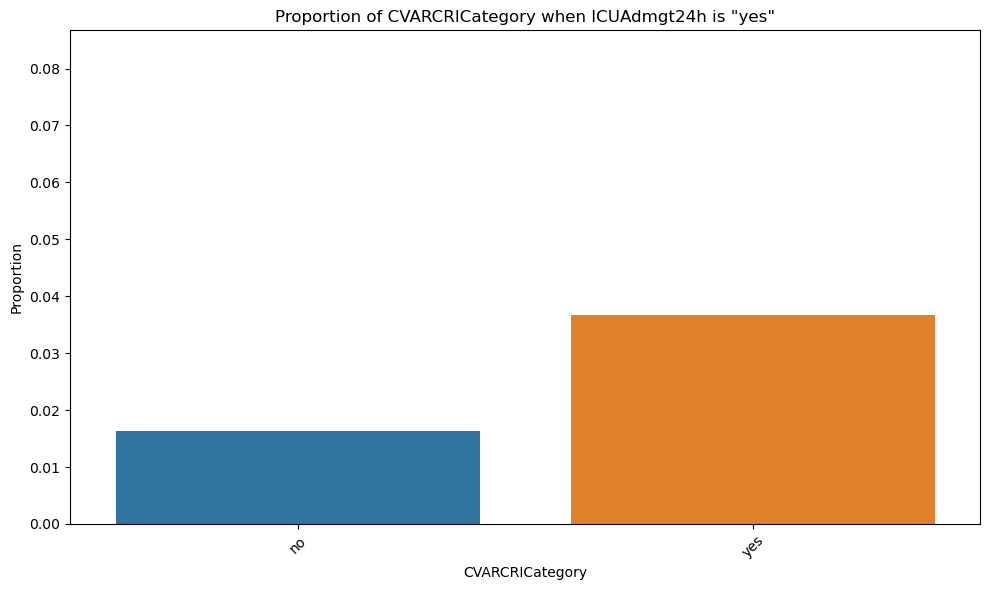

Proportions for IHDRCRICategory when ICUAdmgt24h is 'yes':
IHDRCRICategory
no     0.015021
yes    0.044966
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


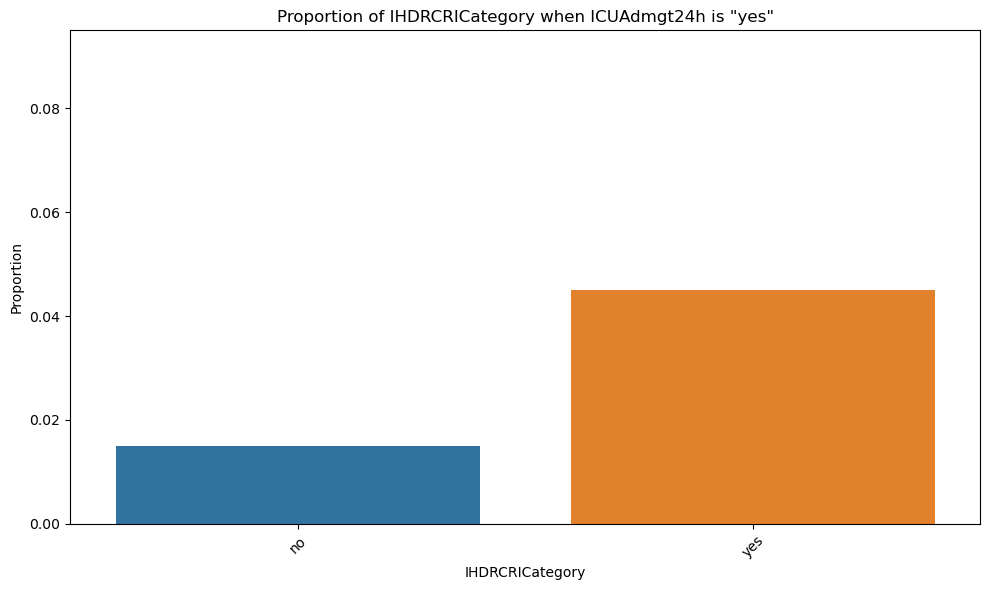

Proportions for CHFRCRICategory when ICUAdmgt24h is 'yes':
CHFRCRICategory
no     0.016112
yes    0.076227
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


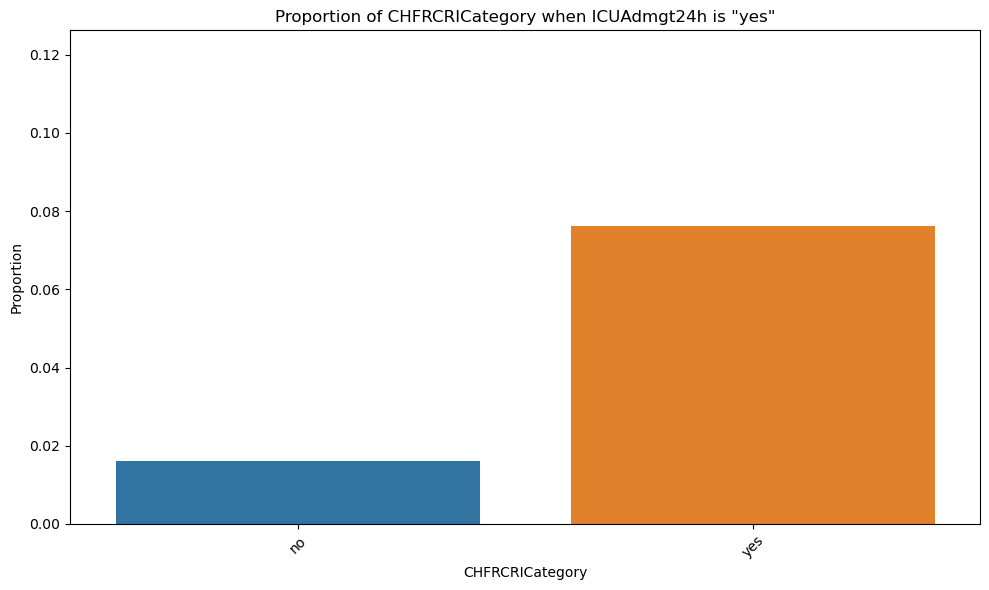

Proportions for DMinsulinRCRICategory when ICUAdmgt24h is 'yes':
DMinsulinRCRICategory
no     0.016429
yes    0.029151
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


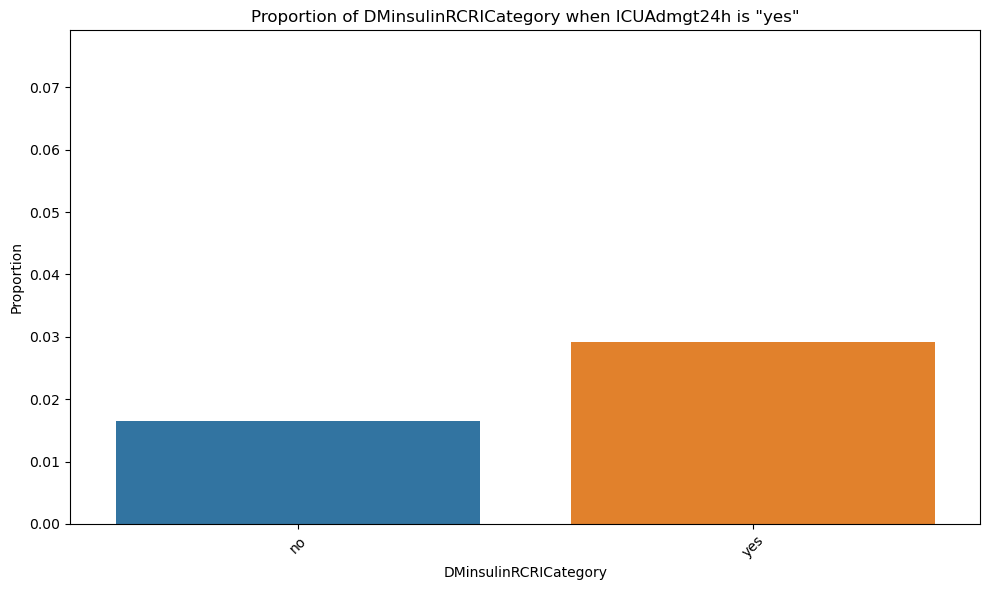

Proportions for CreatinineRCRICategory when ICUAdmgt24h is 'yes':
CreatinineRCRICategory
no     0.015432
yes    0.056728
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


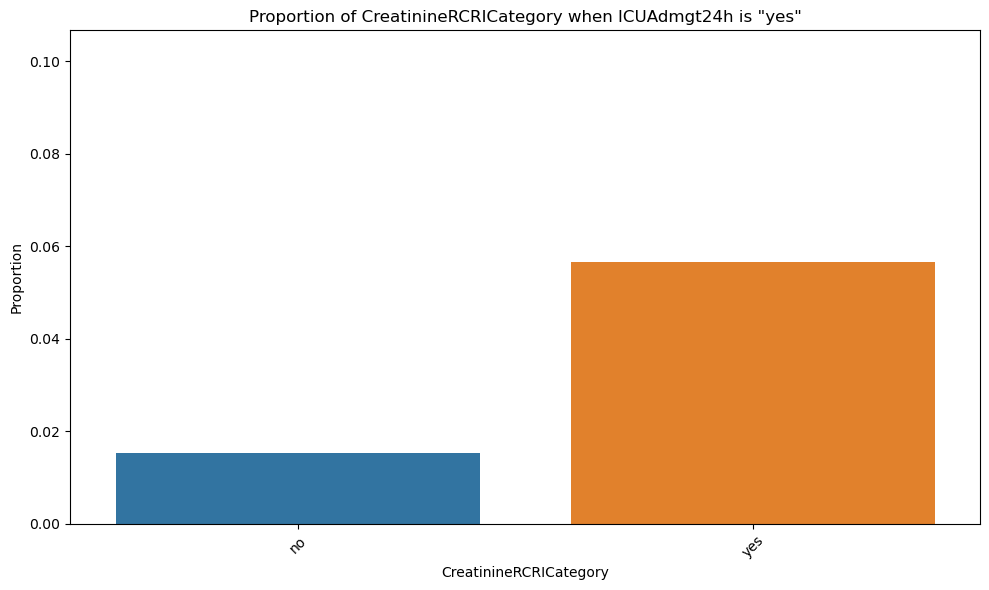

Proportions for GradeofKidneyCategory when ICUAdmgt24h is 'yes':
GradeofKidneyCategory
G1       0.011019
G2       0.013844
G3       0.045365
G4-G5    0.063058
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


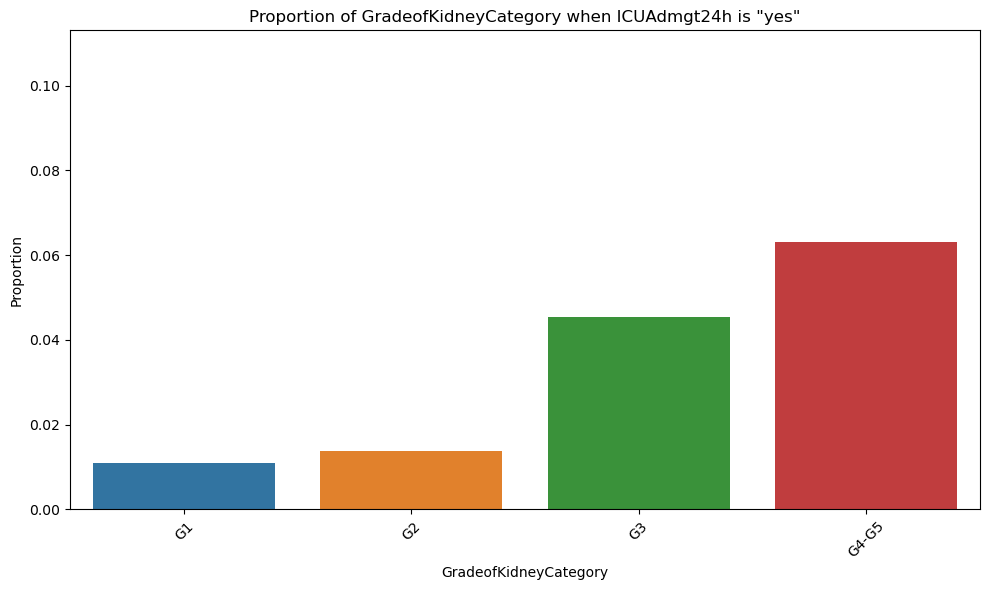

Proportions for RDW15.7 when ICUAdmgt24h is 'yes':
RDW15.7
<= 15.7    0.014399
>15.7      0.035691
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


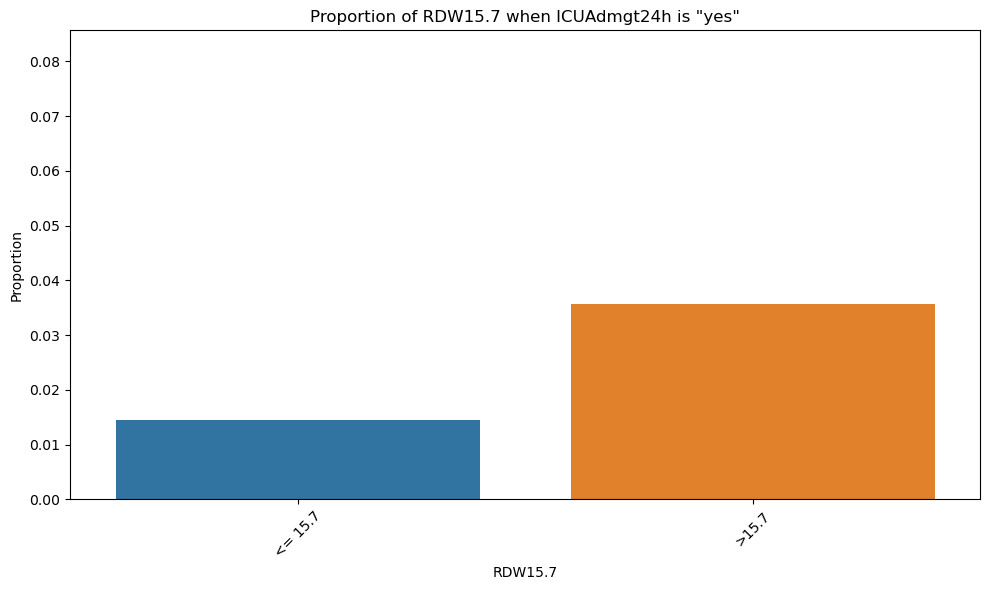

Proportions for ASAcategorybinned when ICUAdmgt24h is 'yes':
ASAcategorybinned
I        0.002773
II       0.008960
III      0.038450
IV-VI    0.235564
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


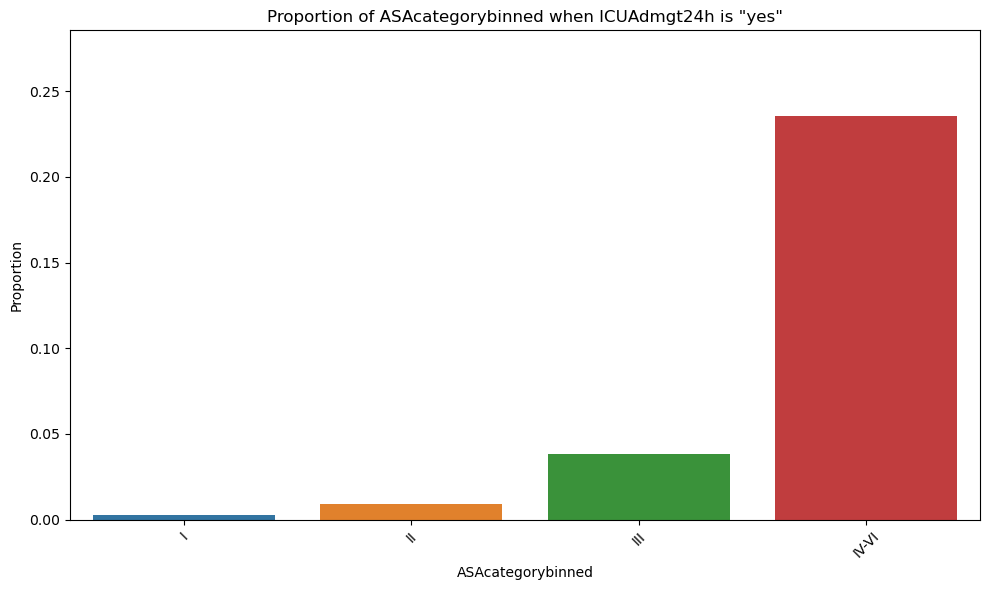

In [12]:
correlation_counts(data, cat_cols)

#### Correlations for Numerical Columns
- Correlation for numerical cols (to drop highly correlated cols for feature reduction)
- Correlations for numerical cols against target variable. 

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Columns')

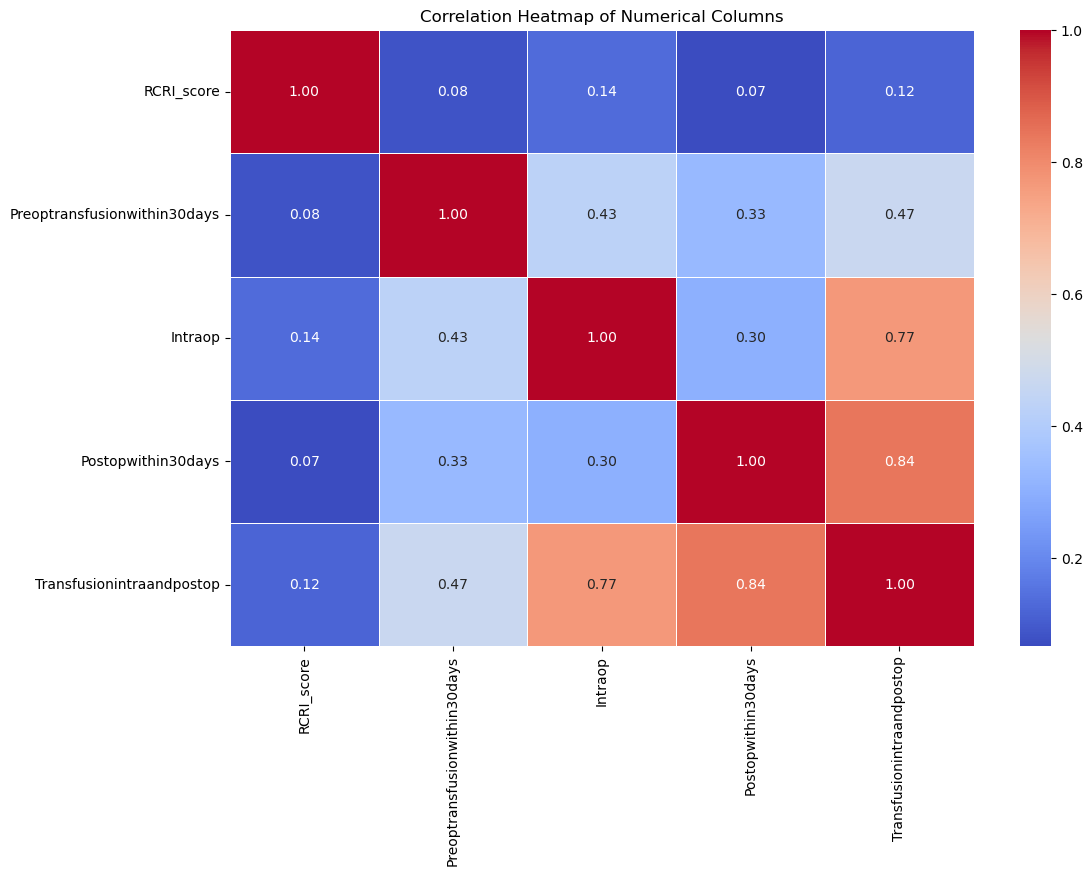

In [13]:
# Compute the correlation matrix
corr_matrix = data[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Columns')

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


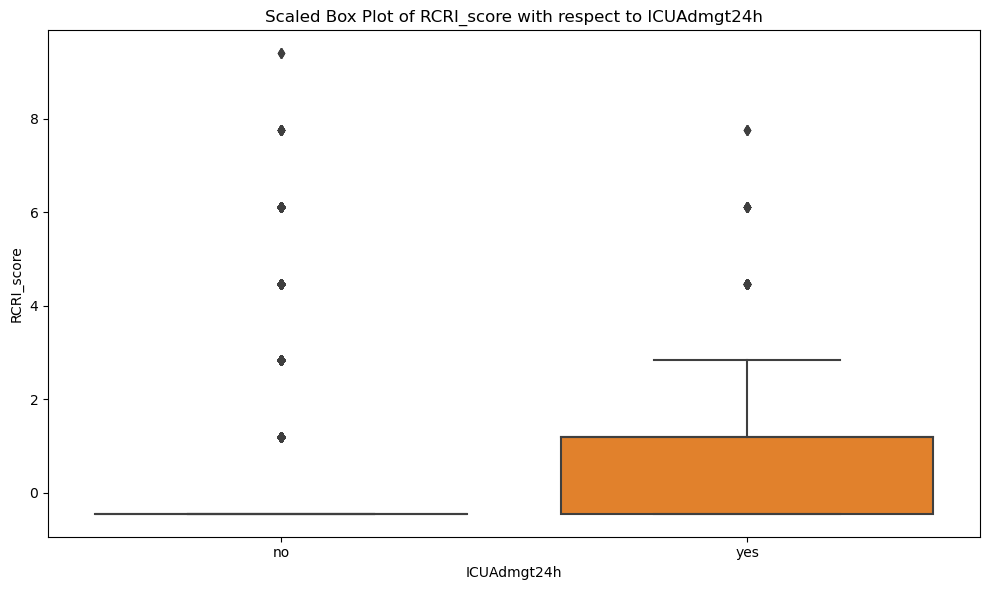

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


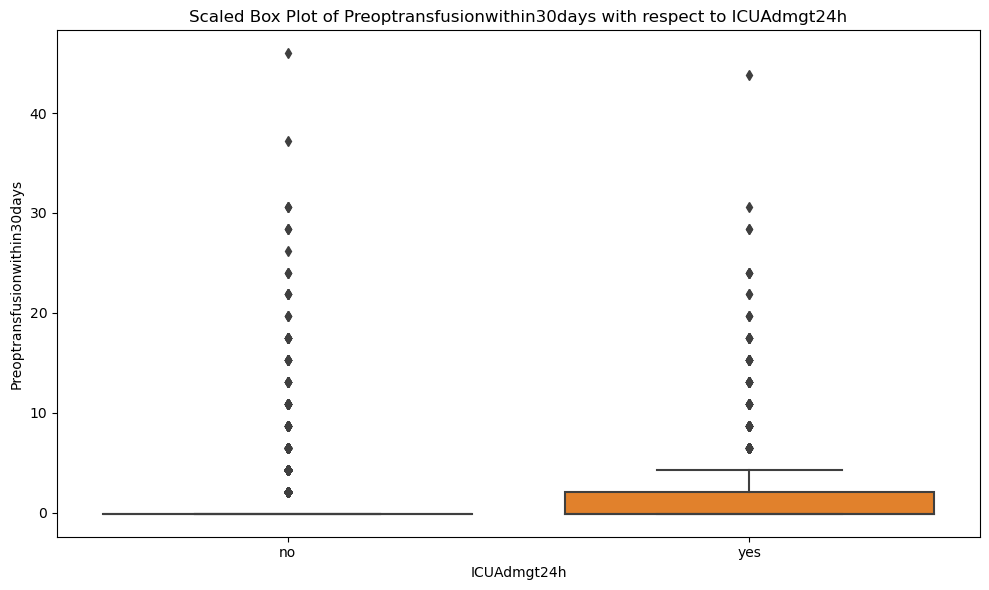

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


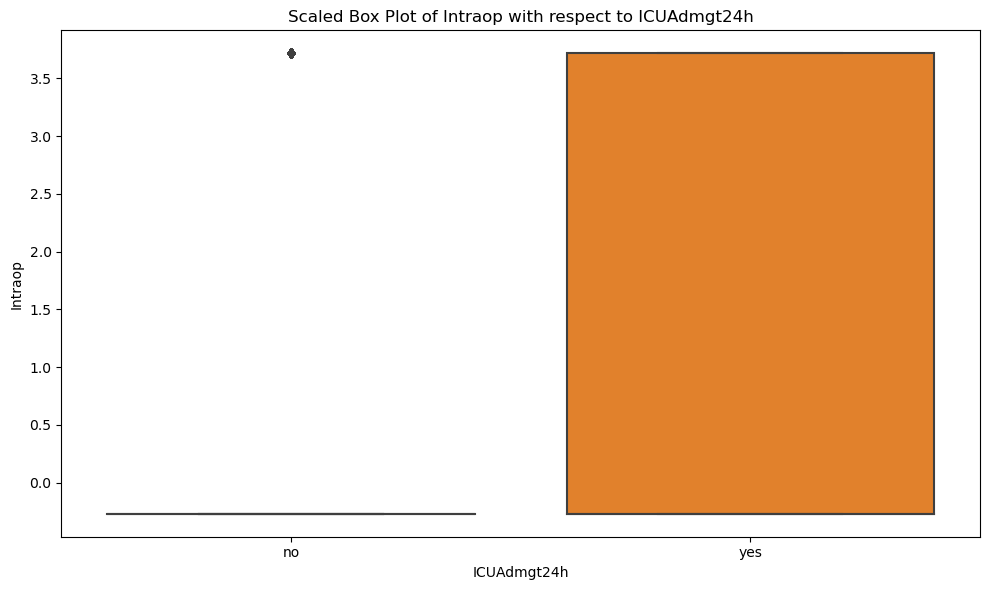

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


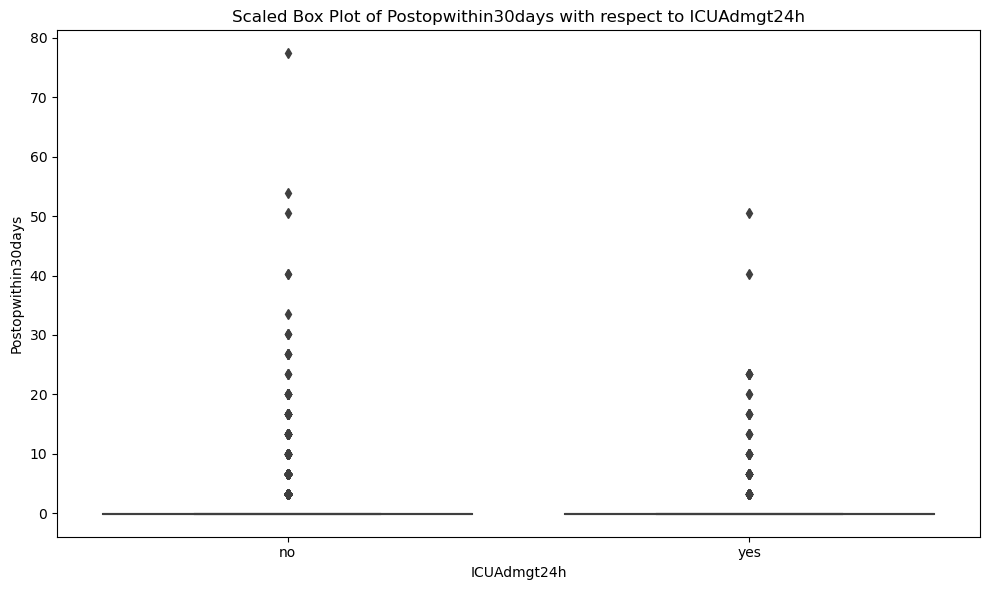

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


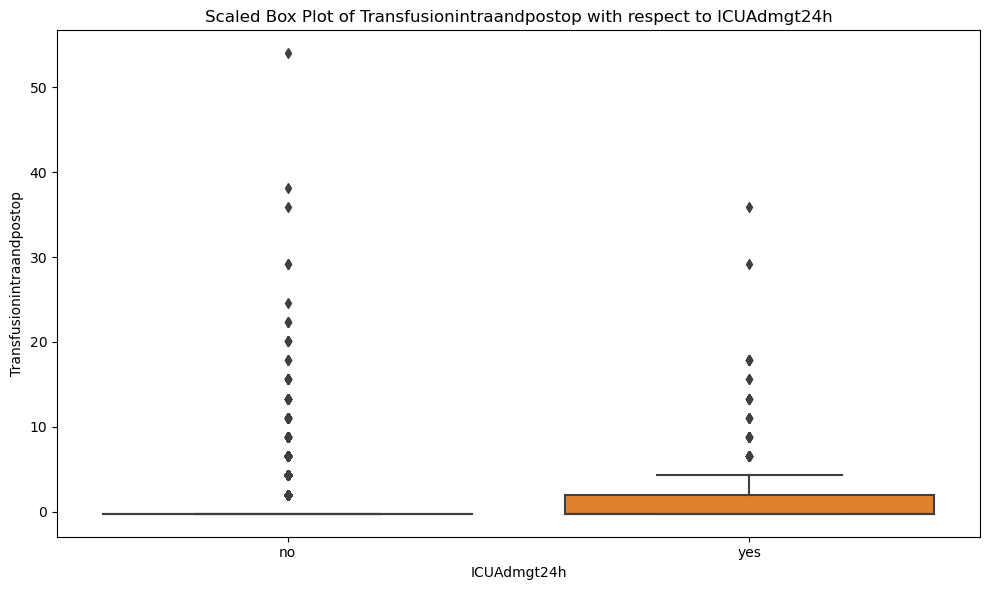

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def visualize_scaled_box_plots(data, target_var='ICUAdmgt24h'):
    """
    Visualize scaled box plots for each numerical column with respect to the target variable.

    Parameters:
    data (pd.DataFrame): The input dataframe.
    target_var (str): The target variable name.

    Returns:
    None
    """
    # Extract numerical columns
    numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
    
    # Remove the target variable from the list of numerical columns
    if target_var in numerical_cols:
        numerical_cols.remove(target_var)
    
    # Ensure the target variable is binary
    if data[target_var].nunique() != 2:
        raise ValueError(f"The target variable {target_var} is not binary.")
    
    # Standard scale the numerical columns (excluding the target variable)
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    
    # Create box plots for each numerical column
    for col in numerical_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=target_var, y=col, data=data)
        plt.title(f'Scaled Box Plot of {col} with respect to {target_var}')
        plt.xlabel(target_var)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming 'data' is your DataFrame
visualize_scaled_box_plots(data, target_var='ICUAdmgt24h')

#### Dataset (further) Exploration

In [15]:
data.columns

Index(['GENDER', 'RCRI_score', 'Anemia category',
       'Preoptransfusionwithin30days', 'Intraop', 'Postopwithin30days',
       'Transfusionintraandpostop', 'AnaestypeCategory', 'PriorityCategory',
       'TransfusionIntraandpostopCategory', 'AGEcategory', 'Mortality',
       'thirtydaymortality', 'SurgRiskCategory', 'RaceCategory',
       'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory',
       'DMinsulinRCRICategory', 'CreatinineRCRICategory',
       'GradeofKidneyCategory', 'RDW15.7', 'ASAcategorybinned', 'ICUAdmgt24h'],
      dtype='object')

In [16]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
categorical_cols

Index(['GENDER', 'Anemia category', 'AnaestypeCategory', 'PriorityCategory',
       'TransfusionIntraandpostopCategory', 'AGEcategory', 'Mortality',
       'SurgRiskCategory', 'RaceCategory', 'CVARCRICategory',
       'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory',
       'CreatinineRCRICategory', 'GradeofKidneyCategory', 'RDW15.7',
       'ASAcategorybinned', 'ICUAdmgt24h'],
      dtype='object')

In [17]:
data['thirtydaymortality'].unique()

array([False,  True])

In [25]:
# # syntax for duckdb.sql
# result = sql("""

# SELECT 
#     a.*

# FROM data AS a

# """).df()

In [41]:
num_cols

['RCRI_score',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop']

### 'thirtydaymortality'

**Important features ('thirtydaymortality')
- Categorical features: ALL except 'GENDER', 'AnaestypeCategory', 'RaceCategory'
- Numerical features: 'RCRI_score', 'Intraop'

In [35]:
type(data["thirtydaymortality"][0])

numpy.bool_

In [31]:
def correlation_counts(data, cat_cols, target_var='thirtydaymortality'):
    """
    Compute and visualize the proportion of each category for categorical variables where target_var equals target_value.

    Parameters:
    data (pd.DataFrame): The input dataframe.
    cat_cols (list): List of categorical columns to analyze.
    target_var (str): The target variable name. Default is 'ICUAdmgt24h'.
    target_value (str): The target value to compute proportions for. Default is 'yes'.

    Returns:
    None
    """
    for col in cat_cols:
        if col in data.columns:
            # Compute the proportions
            total_counts = data[col].value_counts()
            yes_counts = data[data[target_var] == target_value][col].value_counts()
            proportions = yes_counts / total_counts
            proportions = proportions.fillna(0)  # Fill NaN values with 0
            
            print(f"Proportions for {col} when {target_var} is '{target_value}':\n{proportions}\n")
            
            # Plot the proportions
            plt.figure(figsize=(10, 6))
            sns.barplot(x=proportions.index, y=proportions.values)
            plt.title(f'Proportion of {col} when {target_var} is "{target_value}"')
            plt.ylabel('Proportion')
            plt.xlabel(col)
            plt.ylim(0, proportions.max() + 0.05)  # Adjust y-axis scale for better visibility
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column {col} is not in the dataframe.")

Proportions for GENDER when thirtydaymortality is 'True':
GENDER
FEMALE    0.006353
MALE      0.008707
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


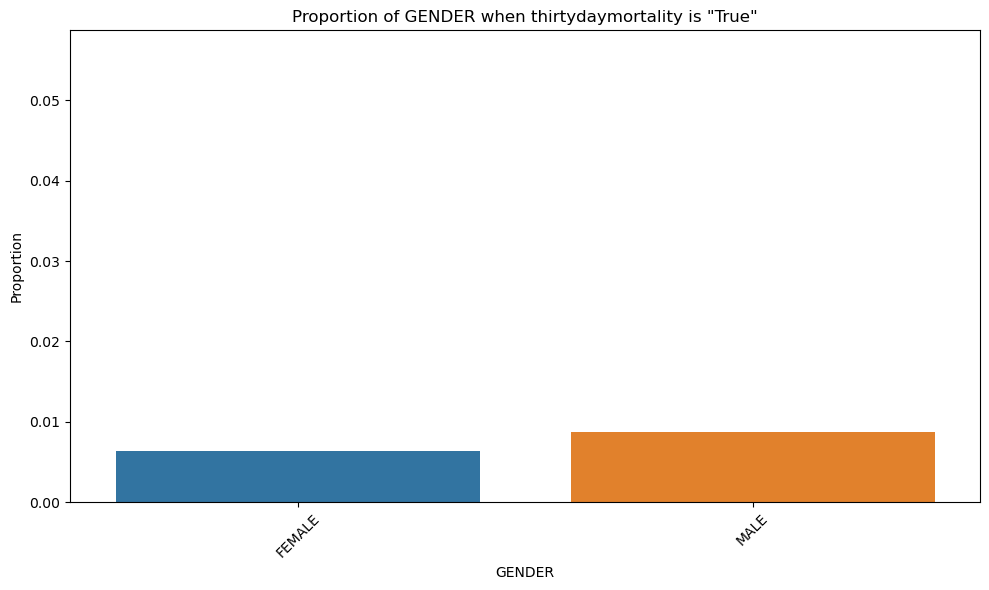

Proportions for Anemia category when thirtydaymortality is 'True':
Anemia category
mild               0.008456
moderate/severe    0.032025
none               0.002224
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


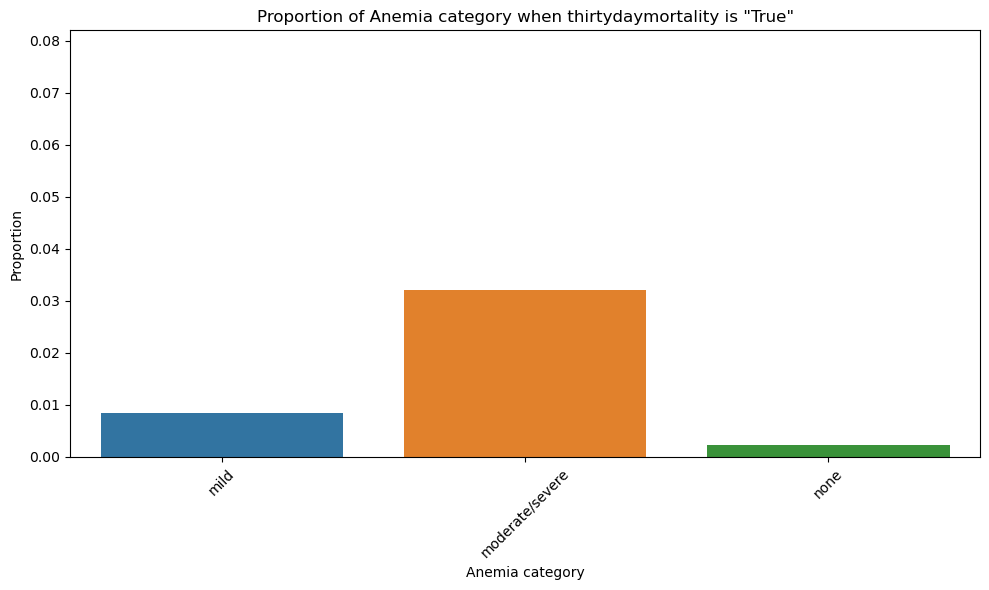

Proportions for AnaestypeCategory when thirtydaymortality is 'True':
AnaestypeCategory
GA    0.007385
RA    0.008228
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


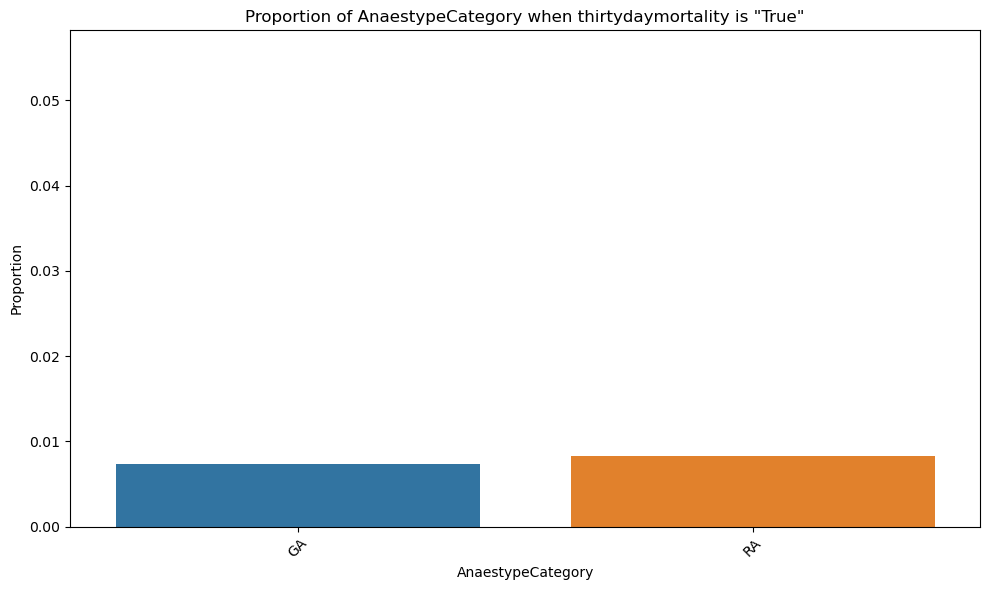

Proportions for PriorityCategory when thirtydaymortality is 'True':
PriorityCategory
Elective     0.003271
Emergency    0.021946
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


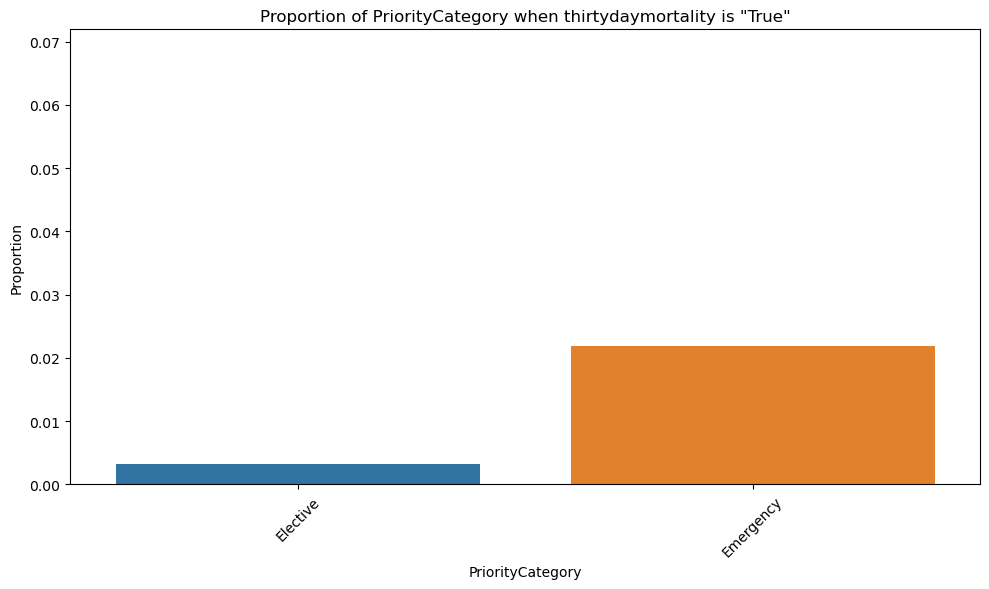

Proportions for TransfusionIntraandpostopCategory when thirtydaymortality is 'True':
TransfusionIntraandpostopCategory
0 units            0.004850
1 unit             0.034265
2 or more units    0.085870
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


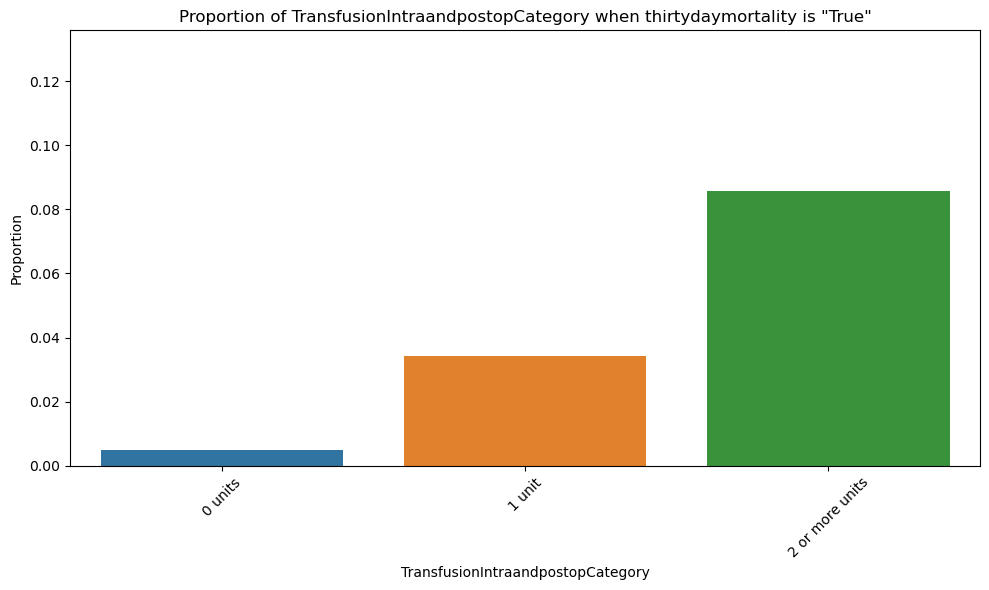

Proportions for AGEcategory when thirtydaymortality is 'True':
AGEcategory
18-29    0.000859
30-49    0.002214
50-64    0.006287
65-74    0.009590
75-84    0.021565
>=85     0.050310
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


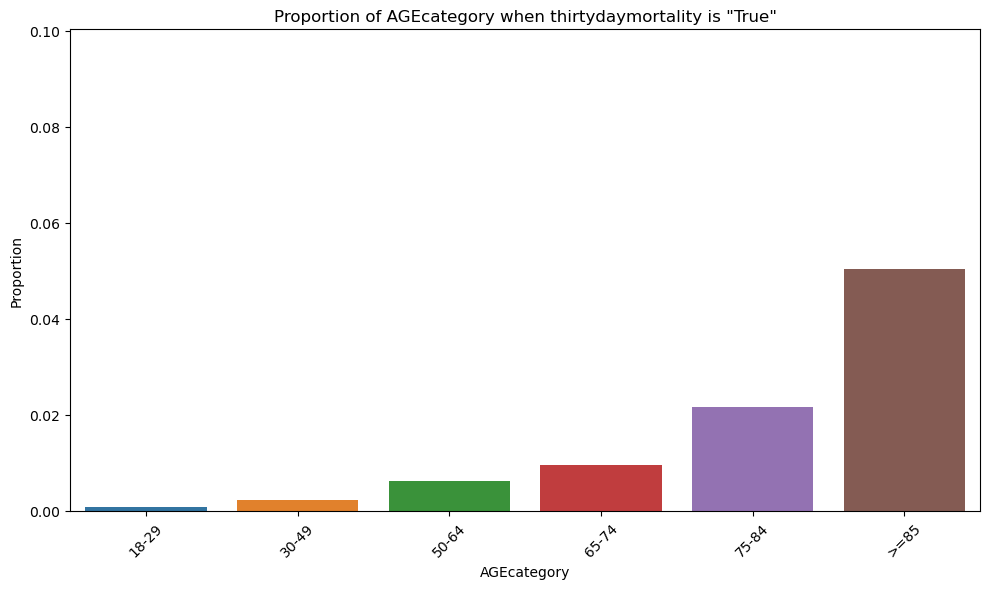

Proportions for SurgRiskCategory when thirtydaymortality is 'True':
SurgRiskCategory
High        0.026406
Low         0.004237
Moderate    0.009196
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


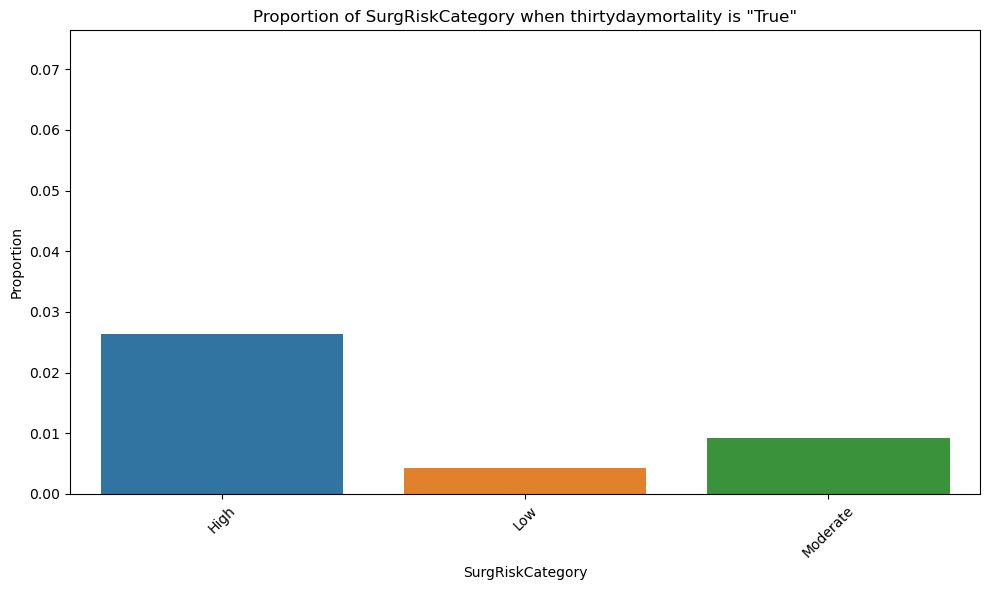

Proportions for RaceCategory when thirtydaymortality is 'True':
RaceCategory
Chinese    0.008024
Indian     0.006352
Malay      0.008209
Others     0.004417
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


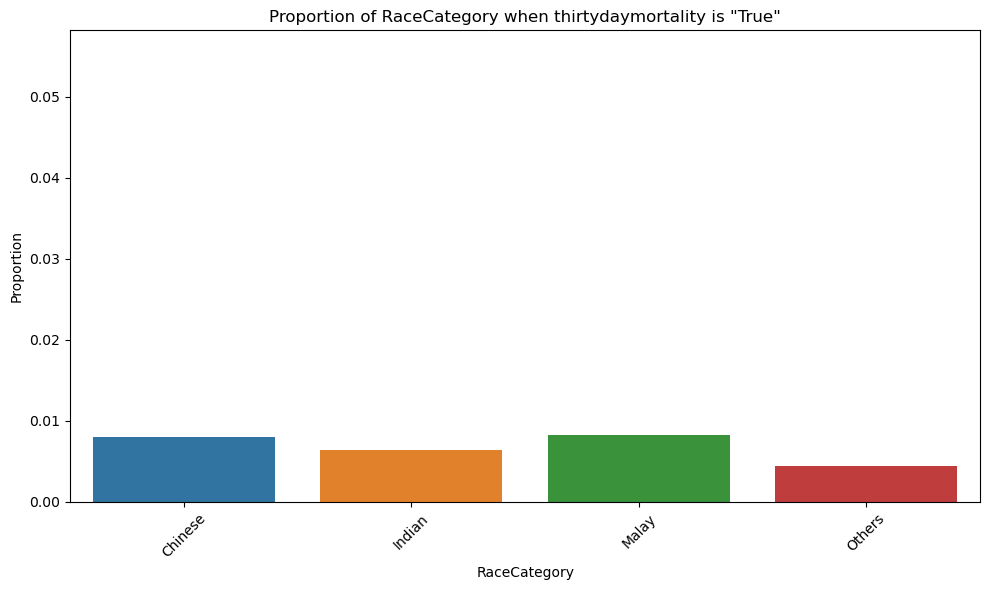

Proportions for CVARCRICategory when thirtydaymortality is 'True':
CVARCRICategory
no     0.007071
yes    0.028037
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


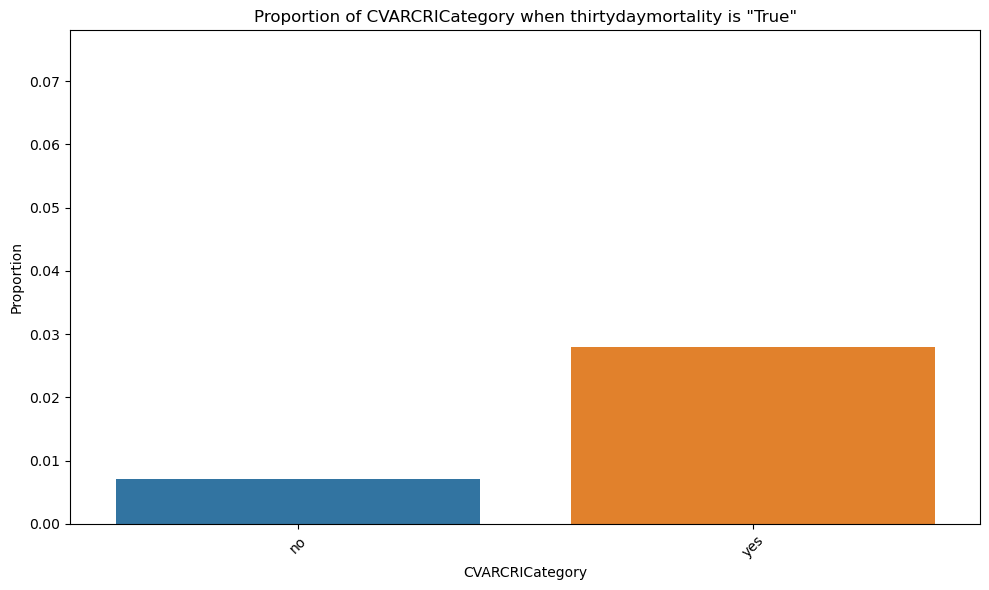

Proportions for IHDRCRICategory when thirtydaymortality is 'True':
IHDRCRICategory
no     0.006085
yes    0.030547
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


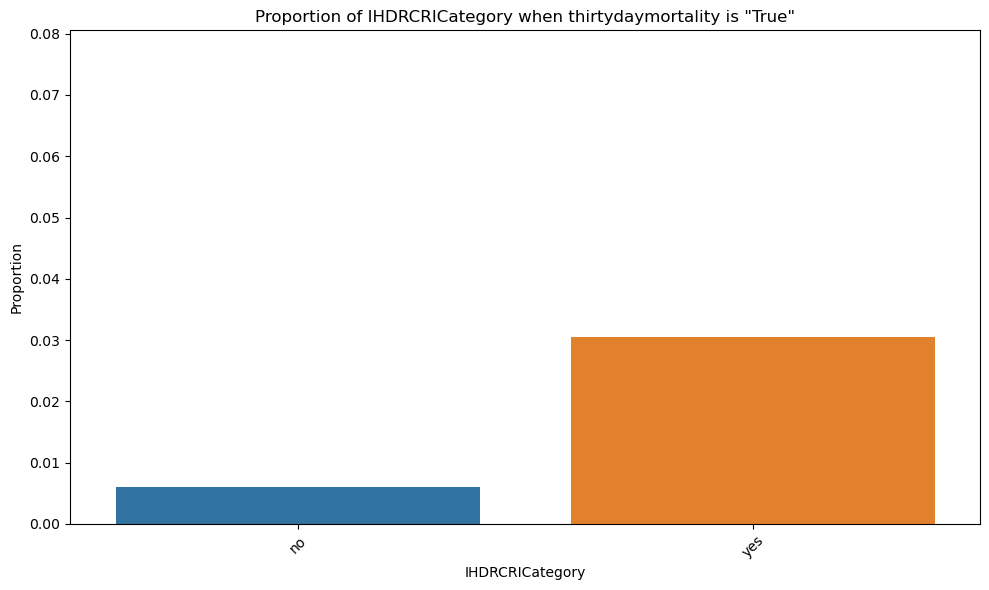

Proportions for CHFRCRICategory when thirtydaymortality is 'True':
CHFRCRICategory
no     0.007098
yes    0.045220
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


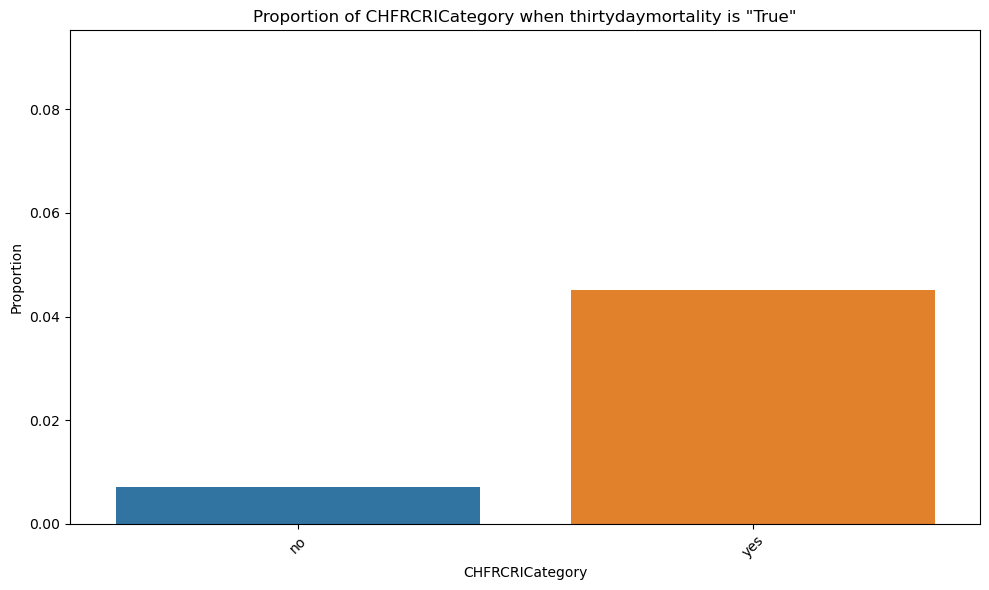

Proportions for DMinsulinRCRICategory when thirtydaymortality is 'True':
DMinsulinRCRICategory
no     0.007159
yes    0.020302
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


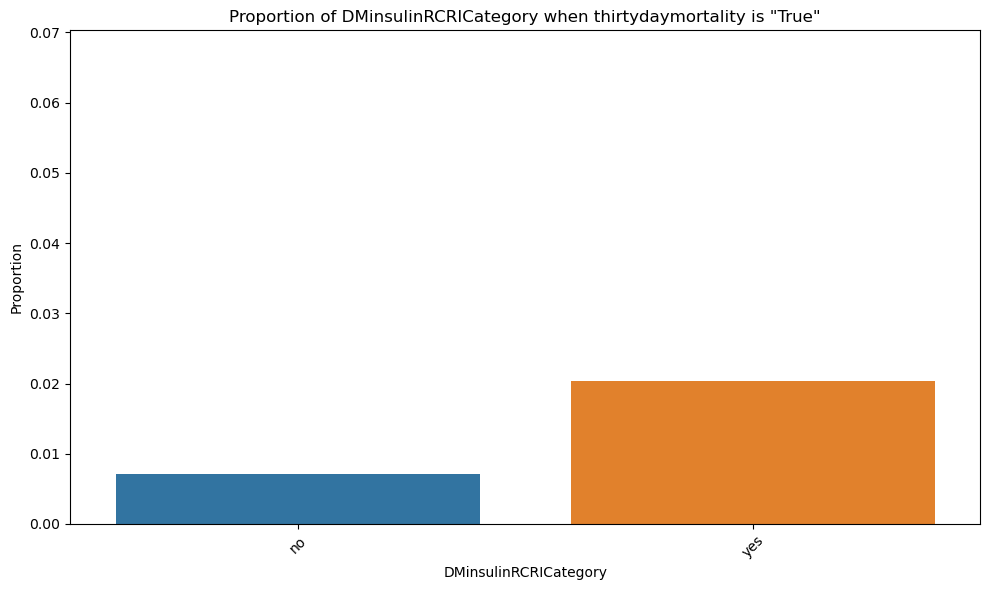

Proportions for CreatinineRCRICategory when thirtydaymortality is 'True':
CreatinineRCRICategory
no     0.006113
yes    0.049252
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


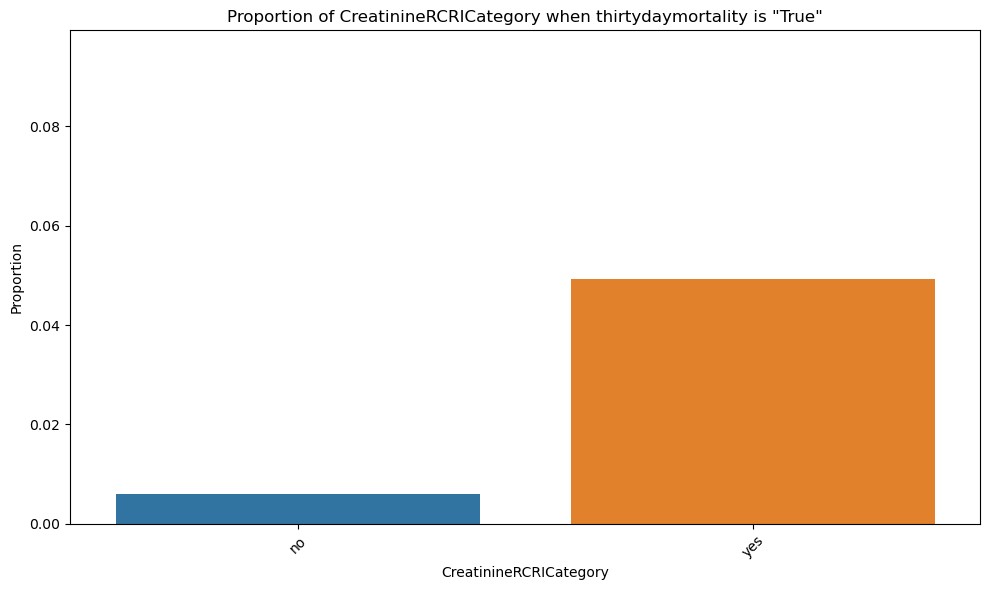

Proportions for GradeofKidneyCategory when thirtydaymortality is 'True':
GradeofKidneyCategory
G1       0.003501
G2       0.004903
G3       0.020998
G4-G5    0.053522
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


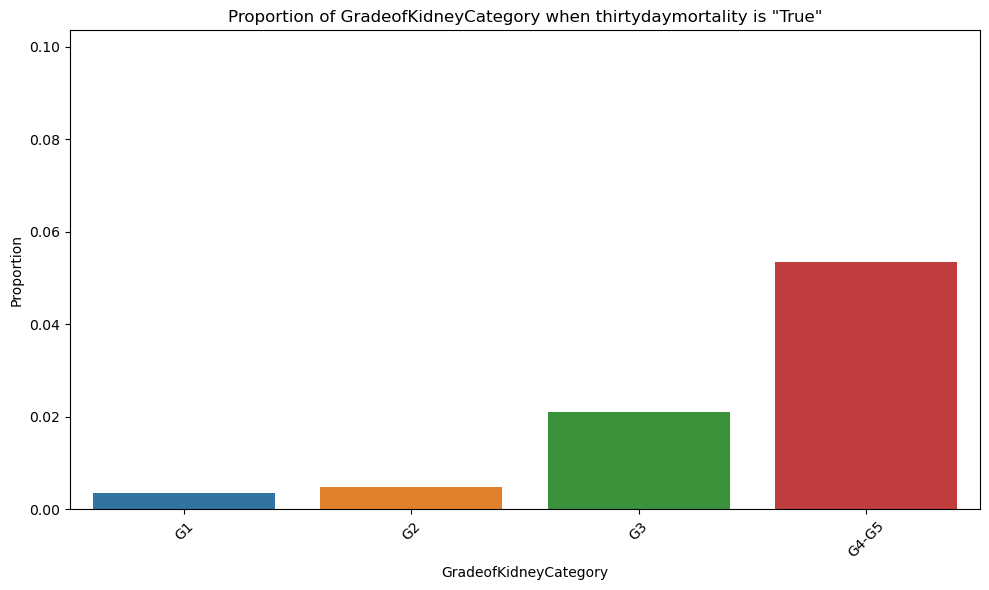

Proportions for RDW15.7 when thirtydaymortality is 'True':
RDW15.7
<= 15.7    0.004848
>15.7      0.028759
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


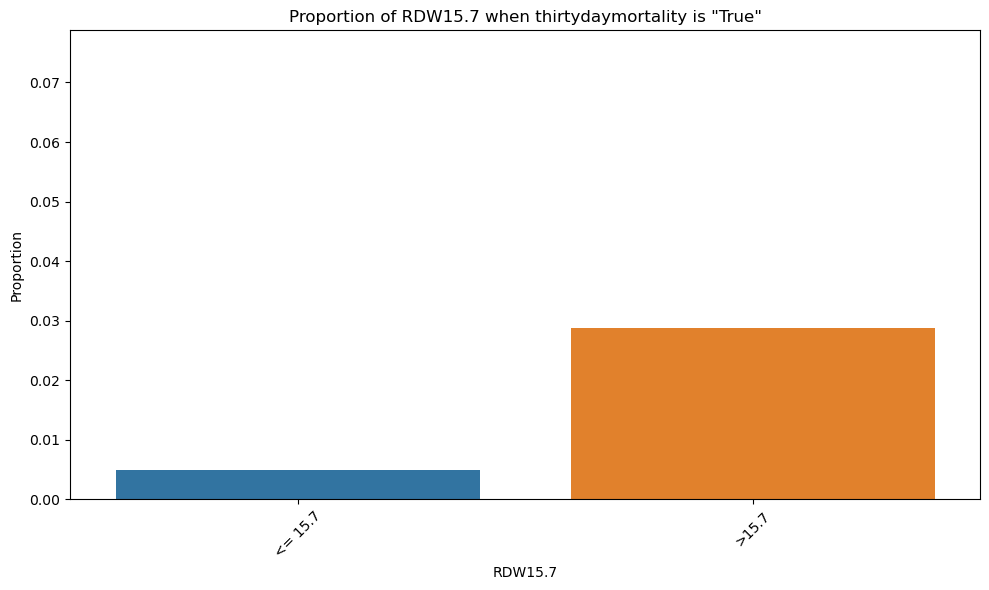

Proportions for ASAcategorybinned when thirtydaymortality is 'True':
ASAcategorybinned
I        0.000567
II       0.002673
III      0.019151
IV-VI    0.140238
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


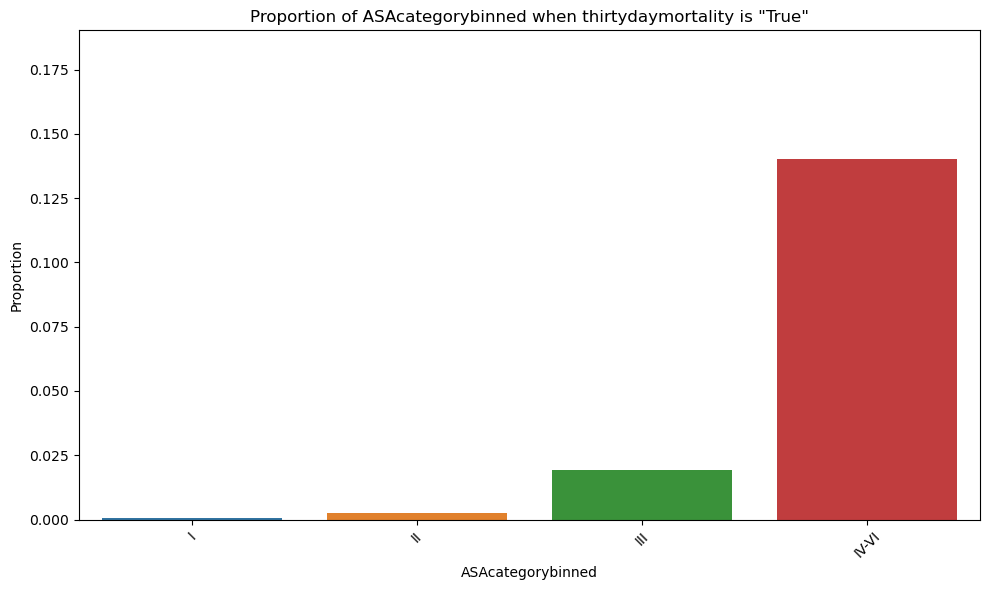

In [36]:
target_value = True
correlation_counts(data, cat_cols)

In [39]:
num_cols

['RCRI_score',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop']

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


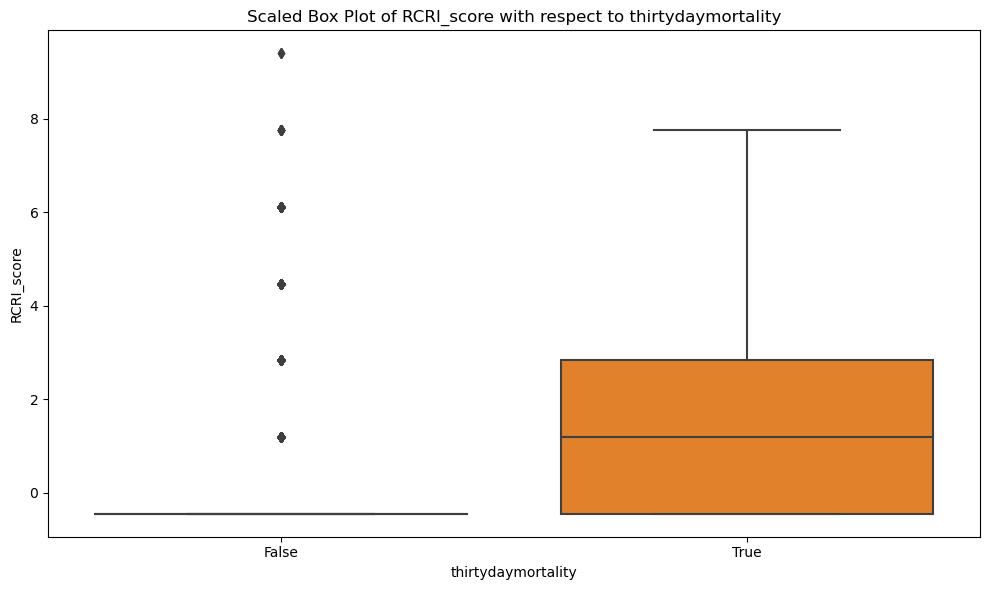

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


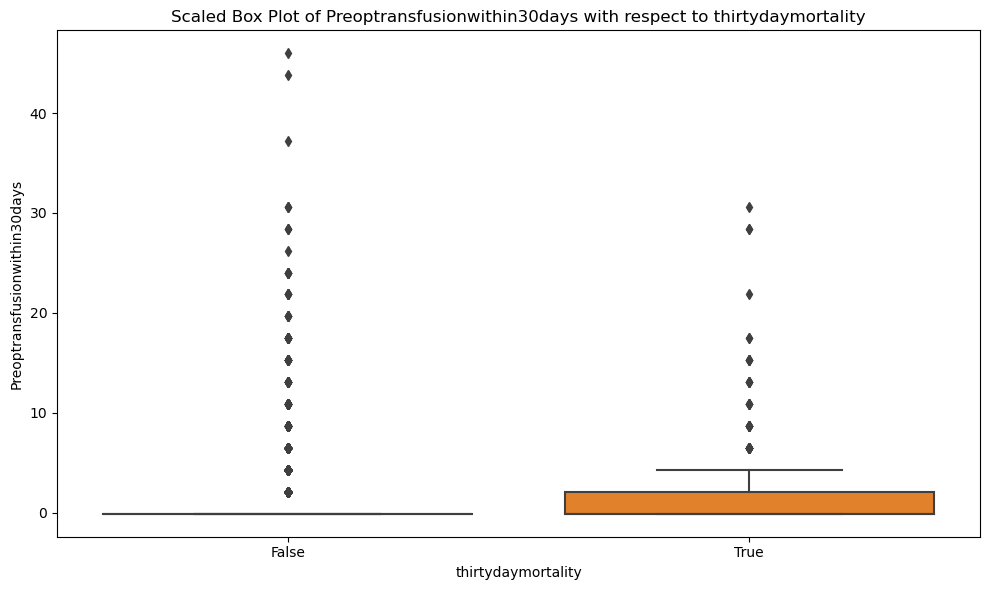

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


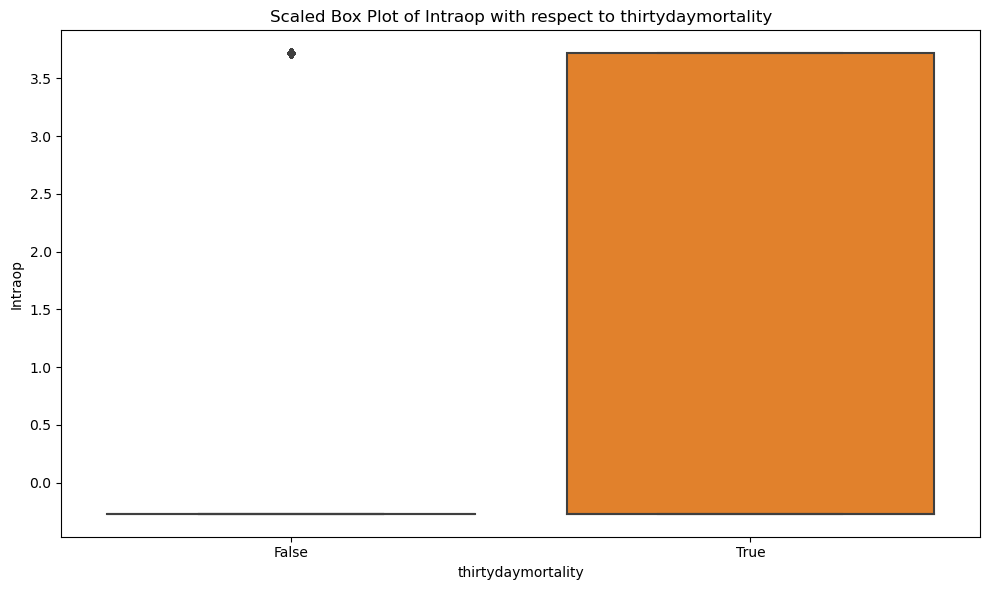

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


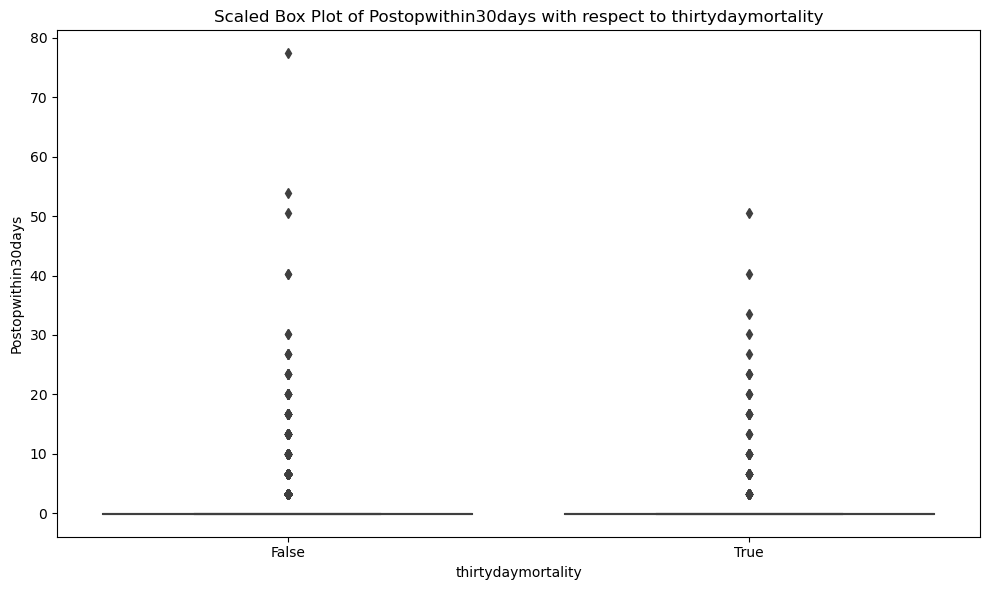

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


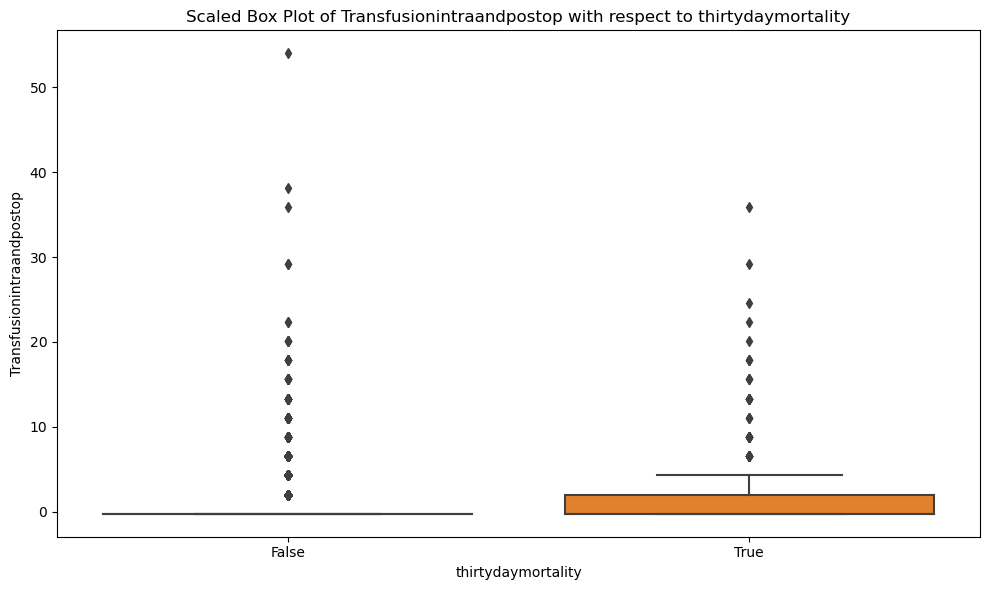

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def visualize_scaled_box_plots(data, target_var='thirtydaymortality'):
    """
    Visualize scaled box plots for each numerical column with respect to the target variable.

    Parameters:
    data (pd.DataFrame): The input dataframe.
    target_var (str): The target variable name.

    Returns:
    None
    """
    # Extract numerical columns
    numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
    
    # Remove the target variable from the list of numerical columns
    if target_var in numerical_cols:
        numerical_cols.remove(target_var)
    
    # Ensure the target variable is binary
    if data[target_var].nunique() != 2:
        raise ValueError(f"The target variable {target_var} is not binary.")
    
    # Standard scale the numerical columns (excluding the target variable)
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    
    # Create box plots for each numerical column
    for col in numerical_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=target_var, y=col, data=data)
        plt.title(f'Scaled Box Plot of {col} with respect to {target_var}')
        plt.xlabel(target_var)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming 'data' is your DataFrame
visualize_scaled_box_plots(data, target_var='thirtydaymortality')